# Task

Develop your own Bayes classifier implementation and compare it to the SciKit-Learn ones: Gaussian Naive Bayes, Multinomial Naive Bayes, Complement Naive Bayes, Bernoulli Naive Bayes. Use the data obtained in the first lab to train the classifiers.

Measure performance of the classifiers - time spent on classifying a single data sample (data point) - and compare performance of your classifier to those of SciKit-Learn.
Measure accuracy of the classifiers and compare accuracy of your classifier to those of SciKit-Learn. 


Upon the completion of the assignement the following must be done (points 1-4 are required to be completed):
1. make confusion matrices for every classifier;
2. determine which classifier is the most accurate;
3. draw histograms of performance for every classifier on a single graph;
4. determine which classifier's performance is the most stable. Use variance of classification time (time spent for classifying a single data sample) as a criteria;
5. *additional score assignment*: find a better criteria of performance stability and use it analogously to point 4. Explain why the criteria is better than the variance.

All of the corresponding information (points 1-4 and 5 if completed) must be displayed as a result of the program execution.

Sci-Kit Learn Naive Bayes documentation: https://scikit-learn.org/stable/modules/naive_bayes.html

---

Разработайте собственную реализацию байесовского классификатора и сравните её с классификаторами из SciKit-Learn: Gaussian Naive Bayes, Multinomial Naive Bayes, Complement Naive Bayes, Bernoulli Naive Bayes. При обучении классификаторов использовать набор данных, полученный при выполнении лабораторной работы 1.

Замерьте прозводительность классификаторов - время, затраченное на классификацию одного экземпляра данных (одна точка) - и сравните производительность разработанного вами классификатора с классификаторами SciKit-Learn.
Замерьте точность классификаторов и сравните точность разработанного вами классификатора с классификаторами SciKit-Learn.

По завершению выполнения работы необходимо (первые 4 пункта обязательны для выполнения):
1. построить матрицы ошибок для каждого классификатора;
2. определить классификатор, имеющий наибольшую точность;
3. построить гистограммы производительности для всех классификаторов, разместив их на одном графике;
4. определить классификатор с наиболее стабильной производительностью. В качестве критерия стабильности использовать дисперсию времени, затраченного на классификацию одного экземпляра данных (одна точка);
5. *задание на дополнительные баллы:* найти более достоверный критерий оценки стабильности производительности и использовать его по аналогии с пунктом 4. Обосновать, почему он является более достоверным.

Соответствующие пункты задания (1-4 и 5, если выполнен) должны быть выведены в результате работы программы.

Документация байесовских классификаторов SciKit-Learn: https://scikit-learn.org/stable/modules/naive_bayes.html


In [1]:
import numpy as np
from time import time
from collections import defaultdict
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Получение датасета из первой лабораторной (гауссовы облака)

In [2]:
df = pd.read_excel('Dataset.xlsx')
df

,x,y,label
0,1.715092,1.698583,2
1,-0.560312,0.864461,0
2,-0.691317,1.670343,0
3,-0.015075,-0.392310,0
4,0.694022,2.900271,2
...,...,...,...
2111,0.455029,-0.379949,0
2112,1.068816,1.484386,0
2113,0.869847,1.140778,1
2114,1.344564,1.453539,1


Сдвиг облаков для получения положительных координат (необходимо для некоторых классификаторов)

In [3]:
data, annotations = df[['x','y']], df['label']
data -= np.min(data)
data.describe()

,x,y
count,2116.000000,2116.000000
mean,4.407814,4.053940
std,1.481061,1.480175
min,0.000000,0.000000
25%,3.361073,3.007592
50%,4.362034,4.061607
75%,5.454149,5.148639
max,8.831553,8.577673


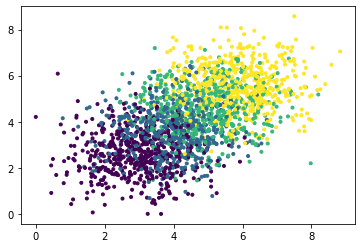

In [4]:
plt.scatter(data['x'], data['y'], c=annotations, marker=".")

Before training a model the dataset must be split into validation set and training set. Validation set is used for testing the model during training and tuning hyperparameters, training set is used for trainng the model. Usually validation set is 25% of all the data (75% is training set, 25% is validation set).

---

Перед обучением модели необходимо разделить весь датасет на валидационную выборку и обучающую выборку. Валидационная выборка используется для тестирования модели по ходу обучения и подбора гиперпараметров, обучающая - для обучения. Обычно валидационная выборка составляет 25% от всех данных.

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, annotations, test_size=0.25, random_state=42)

In [6]:
Xtrain.shape, Xtest.shape

((1587, 2), (529, 2))

## Create Gaussian Naive Bayes Classifier

---

## Создание нового наивного Гауссова классификатора Байеса

In [7]:
class NaiveBayesClassifier():
    def separate_by_classes(self, X, y):
        ''' This function separates our dataset in subdatasets by classes '''
        self.classes = np.unique(y)
        classes_index = {}
        subdatasets = {}
        cls, counts = np.unique(y, return_counts=True)
        self.class_freq = dict(zip(cls, counts))
        for class_type in self.classes:
            classes_index[class_type] = np.argwhere(y==class_type)
            subdatasets[class_type] = X[classes_index[class_type], :]
            self.class_freq[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values()))
        return subdatasets

    def fit(self, X, y):
        ''' The fitting function '''
        separated_X = self.separate_by_classes(X, y)
        self.means = {}
        self.std = {}
        for class_type in self.classes:
            # Here we calculate the mean and the standart deviation from datasets
            self.means[class_type] = np.mean(separated_X[class_type], axis=0)[0]
            self.std[class_type] = np.std(separated_X[class_type], axis=0)[0]

    def calculate_probability(self, x, mean, stdev):
        ''' This function calculates the class probability using gaussian distribution '''
        exponent = np.exp(-((x - mean) ** 2 / (2 * stdev ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent

    def predict_proba(self, X):
        ''' This function predicts the probability for every class '''
        self.class_prob = {cls:np.log(self.class_freq[cls]) for cls in self.classes}
        for cls in self.classes:
            for i in range(len(self.means[cls])):
                self.class_prob[cls]+=np.log(self.calculate_probability(X[i], self.means[cls][i], self.std[cls][i]))
        self.class_prob = {cls: np.e**self.class_prob[cls] for cls in self.class_prob}
        return self.class_prob

    def predict(self, X):
        ''' This funtion predicts the class of a sample '''
        pred = []
        for x in X:
            pred_class = None
            max_prob = 0
            for cls, prob in self.predict_proba(x).items():
                if prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            pred.append(pred_class)
        return pred

Построение классификаторов

In [8]:
# All models in SciKit-Learn have the same interface.
# So it is sufficient to only change the class, all the training and prediction code remains the same.
# Change the model and see how it performs on the data.
# ---
# Все модели в SciKit-Learn имеют один и тот же интерфейс.
# Поэтому достаточно изменить лишь класс, код обучения и получения ответов модели остаётся таким же.
# Попробуйте выбрать другую модель и посмотрите, как она работает на этих данных.
model_Gaus = GaussianNB()
model_Multi = MultinomialNB()
model_Compl = ComplementNB()
model_Bern = BernoulliNB()
model_Baes = NaiveBayesClassifier()

Передача обучающих данных классификаторам

In [9]:
model_Gaus.fit(Xtrain, Ytrain)
model_Multi.fit(Xtrain, Ytrain)
model_Compl.fit(Xtrain, Ytrain)
model_Bern.fit(Xtrain, Ytrain)

model_Baes.fit(Xtrain.to_numpy(), Ytrain.to_numpy())

Предсказание классов экземпляров

In [10]:
pred_Gaus = model_Gaus.predict(Xtest)
pred_Multi = model_Multi.predict(Xtest)
pred_Compl = model_Compl.predict(Xtest)
pred_Bern = model_Bern.predict(Xtest)

pred_Baes = model_Baes.predict(Xtest.to_numpy())

Подсчёт времени предсказания для каждой точки

In [11]:
times = {'Gaus':[], 'Multi':[], 'Compl':[], 'Bern':[], 'Baes': []}
for point in Xtest.values:
  start = time()
  model_Gaus.predict([point])
  times['Gaus'].append(time() - start)

  start = time()
  model_Multi.predict([point])
  times['Multi'].append(time() - start)

  start = time()
  model_Compl.predict([point])
  times['Compl'].append(time() - start)

  start = time()
  model_Bern.predict([point])
  times['Bern'].append(time() - start)

  start = time()
  model_Baes.predict([point])
  times['Baes'].append(time() - start)

df_times = pd.DataFrame(times)
df_times.describe()

,Gaus,Multi,Compl,Bern,Baes
count,529.000000,529.000000,529.000000,529.000000,529.000000
mean,0.000230,0.000088,0.000080,0.000163,0.000110
std,0.000173,0.000035,0.000039,0.000077,0.000024
min,0.000168,0.000057,0.000052,0.000111,0.000087
25%,0.000177,0.000061,0.000055,0.000118,0.000093
50%,0.000192,0.000066,0.000057,0.000125,0.000098
75%,0.000246,0.000118,0.000108,0.000207,0.000123
max,0.002954,0.000354,0.000574,0.001189,0.000282


Подсчёт точности

In [12]:
def evaluate(P, T):
    accuracy = np.mean(P == T)
    return f"{accuracy*100} %"

In [13]:
accuracy = {'Gaus':evaluate(pred_Gaus, Ytest), 
         'Multi':evaluate(pred_Multi, Ytest), 
         'Compl':evaluate(pred_Compl, Ytest), 
         'Bern':evaluate(pred_Bern, Ytest), 
         'Baes':evaluate(pred_Baes, Ytest) }
df_accuracy = pd.DataFrame(accuracy, index=["accuracy"])
df_accuracy

,Gaus,Multi,Compl,Bern,Baes
accuracy,64.46124763705104 %,25.51984877126654 %,27.599243856332706 %,23.440453686200378 %,62.003780718336486 %


In [14]:
top_acc = np.max(df_accuracy.values)
print(f"Classifier with maximum accuracy is Gaussian (acc = {top_acc})")

Classifier with maximum accuracy is Gaussian (acc = 64.46124763705104 %)


In [15]:
conf_mat_Gaus = confusion_matrix(Ytest, pred_Gaus)
conf_mat_Multi = confusion_matrix(Ytest, pred_Multi)
conf_mat_Compl = confusion_matrix(Ytest, pred_Compl)
conf_mat_Bern = confusion_matrix(Ytest, pred_Bern)
conf_mat_Baes = confusion_matrix(Ytest, pred_Baes)

Матрица ошибок GaussianNB



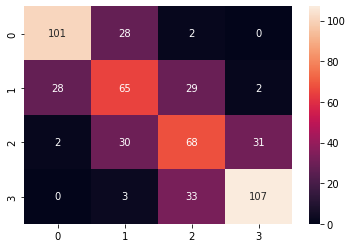

In [16]:
sns.heatmap(conf_mat_Gaus, annot=True, fmt="d")

Матрица ошибок MultinomialNB

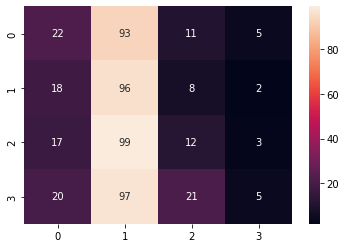

In [17]:
sns.heatmap(conf_mat_Multi, annot=True, fmt="d")

Матрица ошибок ComplementNB

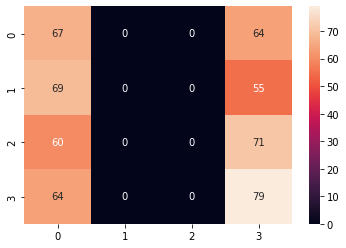

In [18]:
sns.heatmap(conf_mat_Compl, annot=True, fmt="d")

Матрица ошибок BernoulliNB

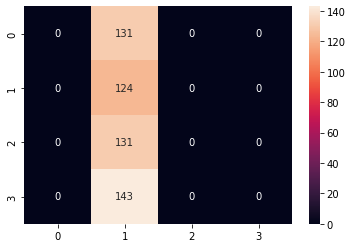

In [19]:
sns.heatmap(conf_mat_Bern, annot=True, fmt="d")

Матрица ошибок собственного Байесовского классификатора

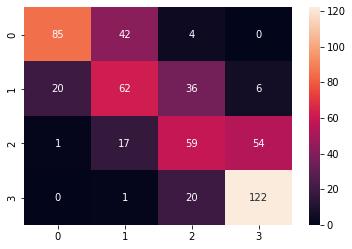

In [20]:
sns.heatmap(conf_mat_Baes, annot=True, fmt="d")

Гистограмма производительности

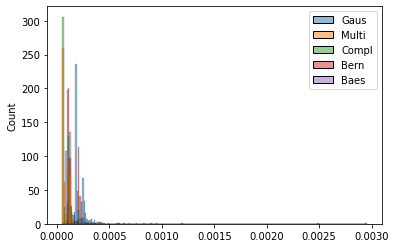

In [21]:
sns.histplot(df_times)

Дисперсия производительности каждого классификатора

In [22]:
variance_times = np.var(df_times)
variance_times

Gaus     2.993586e-08
Multi    1.199695e-09
Compl    1.487415e-09
Bern     5.941925e-09
Baes     5.572037e-10
dtype: float64

In [25]:
min_var = np.min(variance_times)
print(f"The classifier with the highest stability: {min_var}")

The classifier with the highest stability: 5.572036620442562e-10
